Copyright (c) 2020 [Qadeer Aziz](qadeerahh@gmail.com)

https://github.com/kadeeraziz/pashtotagger

[MIT License](https://github.com/kadeeraziz/pashtopos/master/LICENSE.txt)

Note that the optional watermark extension is a small IPython notebook plugin that developed by [Sebastian Raschka](https://sebastianraschka.com)(https://github.com/rasbt/watermark) for printing date and time stamps, version numbers, and hardware information. You can just skip the following line(s).

In [43]:
%load_ext watermark
%watermark -a "Qadeer Ah. Aziz" -v -m -u -d -p numpy,pandas

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Author: Qadeer Ah. Aziz

Last updated: 2020-12-09

Python implementation: CPython
Python version       : 3.8.4
IPython version      : 7.16.1

numpy : 1.19.0
pandas: 1.0.5

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.39-linuxkit
Machine     : x86_64
Processor   : x86_64
CPU cores   : 4
Architecture: 64bit



### Support Vector Machines: Fit and evaluate the Tagger [sklearn.svm.SVC](https://scikitlearn.org/stable/modules/generated/sklearn.svm.SVC.html)

In this notebook, we will fit and evaluate the Support Vector Machines tagger.

### Overview

- [Loading required packages](#Loading-required-packages)
- [Read the corpus](#Read-the-corpus)
- [Spliting the data into three different sets](#Spliting-the-data-into-three-different-sets)
- [Feature extraction](#Feature-extraction)`
- [Fitting 5-fold cross validation](#Fitting-5-fold-cross-validation)
- [Saving the best model](#Saving-the-best-model)
- [Testing the best model (cross validated) on validation set](#Testing-the-best-model-(cross-validated)-on-validation-set)
- [Classification report](#Classification-report)

### Loading required packages

In [68]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import joblib
import warnings
from time import time

from sklearn.metrics import make_scorer

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

### Read the corpus

In [69]:
corpus = pd.read_excel('corpus.xlsx')
corpus.head()

,token,tag,pos
0,امریکایي,ADJ,adjective
1,فضانوردې,NOUN,noun
2,کریستینا کوچ,NOUN,noun
3,،,PUNCT,punctuation
4,په,PRT,particle


In [70]:
sents = []
sent=[]
for i, token, tag, pos in corpus.itertuples():
    sent.append((token, tag))
    if (token == '.'):
        sents.append(sent)
        sent = []
        continue

In [71]:
print('Number of words in the corpus: {}'.format(len(corpus['token'])))
print('Number of sentences in the corpus: {}'.format(len(sents)))

Number of words in the corpus: 41928
Number of sentences in the corpus: 1219


### Feature extraction 

In [72]:
def extract_features(token, index, sent):
    """Extract features of given word(token)"""
    return {    
        'token'             : token,                                   
        'is_first'          : index == 0,                         
        'is_last'           : index == len(sent)-1,              
                        

        'prefix-1'          : token[0],                                 
        'prefix-2'          : '' if len(token) < 2  else token[:1],     
        'prefix-3'          : '' if len(token) < 3  else token[:2],
        
        
        'suffix-1'          : token[-1],                                
        'suffix-2'          : '' if len(token) < 2  else token[-2:],
        'suffix-3'          : '' if len(token) < 3  else token[-3:],
        

        'prev-token'        : '' if index == 0     else sent[index - 1][0],     
        '2-prev-token'      : '' if index <= 1     else sent[index - 2][0],     

        'next-token'        : '' if index == len(sent) - 1     else sent[index + 1][0],     
        '2-next-token'      : '' if index >= len(sent) - 2     else sent[index + 2][0],
        
        'has_hyphen': '-' in sent[index],
        'is_numeric': token.isdigit(),
        }

In [73]:
def transform_to_dataset(tagged_sentences):
  X, y = [], []
  for sent in tagged_sentences:

    for index, tokens in enumerate(sent):
        token = tokens[0]
        X.append(extract_features(token, index, sent))
        tags = tokens[1]
        y.append(tags)
        
  return X, y

### Spliting the data into three different sets

In [74]:
train_size = int(0.6*len(sents))
train = sents[:train_size]
testing = sents[train_size:]
test_size = int(0.5*len(testing))
test = testing[:test_size]
val = testing[test_size:]

In [75]:
X_train, y_train = transform_to_dataset(train)
X_test, y_test = transform_to_dataset(test)
X_val, y_val = transform_to_dataset(val)

### Victorization

In [76]:
vectorizer = DictVectorizer()  
#vectorizer.fit(X_train)                                    # Train vectorizer
X_train_vectorized = vectorizer.fit_transform(X_train)  
X_val_vectorized = vectorizer.transform(X_val) 
X_test_vectorized = vectorizer.transform(X_test) 

In [77]:
def print_results(results):
    print('BEST PARAMS: {}\n'.format(results.best_params_))

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean, 4), round(std * 2, 4), params))

In [78]:
labels = corpus['tag'].unique()
f1_scorer = make_scorer(f1_score,
                        average='macro', labels=labels)

### Fitting 5-fold cross validation

In [79]:
svc = SVC()
parameters = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10]
}


cv = GridSearchCV(svc,
                  parameters,
                  cv=5,
                  n_jobs=-1,
                  scoring=f1_scorer)
cv.fit(X_train_vectorized, y_train)
print_results(cv)

BEST PARAMS: {'C': 1, 'kernel': 'linear'}

0.9044 (+/-0.0499) for {'C': 0.1, 'kernel': 'linear'}
0.6098 (+/-0.0274) for {'C': 0.1, 'kernel': 'rbf'}
0.94 (+/-0.0612) for {'C': 1, 'kernel': 'linear'}
0.8928 (+/-0.0633) for {'C': 1, 'kernel': 'rbf'}
0.9391 (+/-0.0601) for {'C': 10, 'kernel': 'linear'}
0.9236 (+/-0.0656) for {'C': 10, 'kernel': 'rbf'}


### Saving the best model

In [1]:
print(cv.cv_result_)

NameError: name 'cv' is not defined

In [80]:
joblib.dump(cv.best_estimator_, './models/svm_model.pkl')

['./models/svm_model.pkl']

### Testing the best model (cross validated) on validation set

In [81]:
svm_model = joblib.load('./models/svm_model.pkl')

In [82]:
start = time()
pred_val = svm_model.predict(X_val_vectorized)
end = time()

In [83]:
accuracy = round(accuracy_score(y_val, pred_val), 4)
precision = round(precision_score(y_val, pred_val, average='macro'), 4)
recall = round(recall_score(y_val, pred_val, average='macro'), 4)
f1score = round(f1_score(y_val, pred_val, average='macro'), 4)

In [84]:
print('Accuracy: {} '.format(accuracy))
print('F1-score: {} '.format(f1score))
print('Precision: {} '.format(precision))
print('Recall: {} '.format(recall))
print('Latency: {}ms'.format(round((end - start)*1000, 1)))

Accuracy: 0.9461 
F1-score: 0.9454 
Precision: 0.9616 
Recall: 0.9331 
Latency: 11562.1ms


In [85]:
#print(classification_report(y_val, pred_val, target_names=corpus['tag'].unique()))
clf_report = classification_report(y_val, 
                                   pred_val, 
                                   target_names=sorted(corpus['tag'].unique()),
                                   labels=corpus['tag'].unique(),
                                   output_dict=True)

In [86]:
from sklearn import metrics

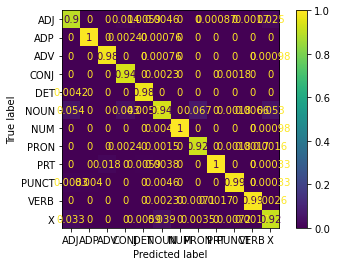

In [30]:
disp = metrics.plot_confusion_matrix(best_cv_model, X_val_vectorized, y_val, normalize='pred')

In [87]:
sns.set('paper', 'white',
        rc={'font.size': 10, 'axes.labelsize': 10,
            'legend.fontsize': 10, 'axes.titlesize': 10,
            'xtick.labelsize': 10,'ytick.labelsize': 10, 
            "pgf.rcfonts": True,
           })
plt.rc('font', **{'family': 'serif', 'serif': ['Times']})
plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.15)
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

<Figure size 432x288 with 0 Axes>

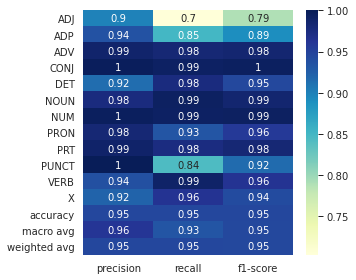

In [88]:
plt.figure(figsize=(5, 4))
fig = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T,
                  annot=True, annot_kws={'size': 10},
                  cbar=1,
                  linewidths=0,
                  linecolor='white',
                  cmap="YlGnBu"
                  )


In [42]:
f = fig.get_figure()
f.autolayout : True
f.savefig('svm_matrix1.png', dpi=400)

In [89]:
from sklearn.metrics import confusion_matrix
from cf_matrix import make_confusion_matrix
categories = sorted(corpus['tag'].unique())
confusion_matrix = confusion_matrix(y_val, pred_val, normalize='true', labels=categories)

In [63]:
vminn = np.min(confusion_matrix)
vmaxx = np.max(confusion_matrix)

Text(0.5, 6.799999999999994, 'Predicted')

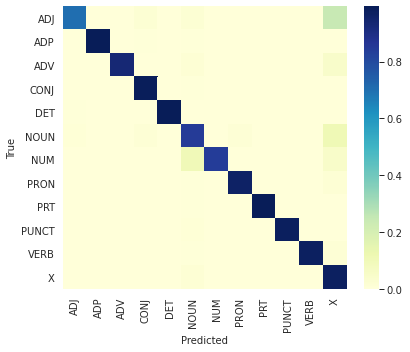

In [90]:
plt.figure(figsize=(6, 5))
fig = sns.heatmap(confusion_matrix,
                  annot=False, annot_kws={'size': 10},
                  vmax=vmaxx,
                  vmin=vminn,
                  cbar=True,
                  linewidths=0,
                  linecolor='white',
                  cmap="YlGnBu",
                  #fmt='',
                  xticklabels=categories,
                  yticklabels=categories,
                  #cbar_kws={'ticks':[]}
                  )
plt.ylabel('True')
plt.xlabel('Predicted')

#cbar = fig.collections[0].colorbar
#cbar.set_ticks([0, .2, .4, .6, .8, 1])
#cbar.set_ticklabels(['0.0', '0.2', '0.4', '0.6', '0.8', '1.0'])


In [65]:
f = fig.get_figure()
f.autolayout : True
f.savefig('svm_matrix2.png', dpi=400)